In [1]:
## Select packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from cil.processors import Normaliser
from cil.framework import AcquisitionGeometry, AcquisitionData, ImageGeometry, ImageData
from cil.utilities.display import show2D, show_geometry
from cil.io import TIFFWriter, TIFFStackReader
from cil.plugins.astra import FBP
import create_phantom as cph
from scipy.ndimage import median_filter

In [111]:
upper_path = '/work3/msaca/simulation_data/experiment_2/'
subfolder_normalizations = 'normalizations/'


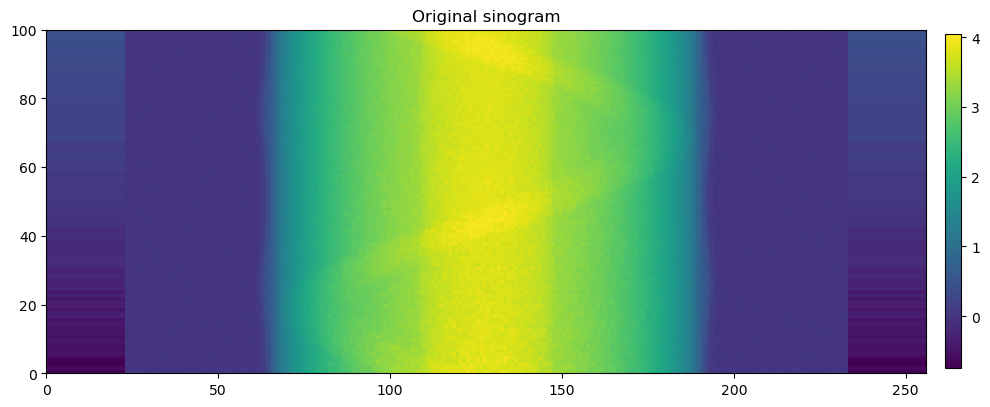

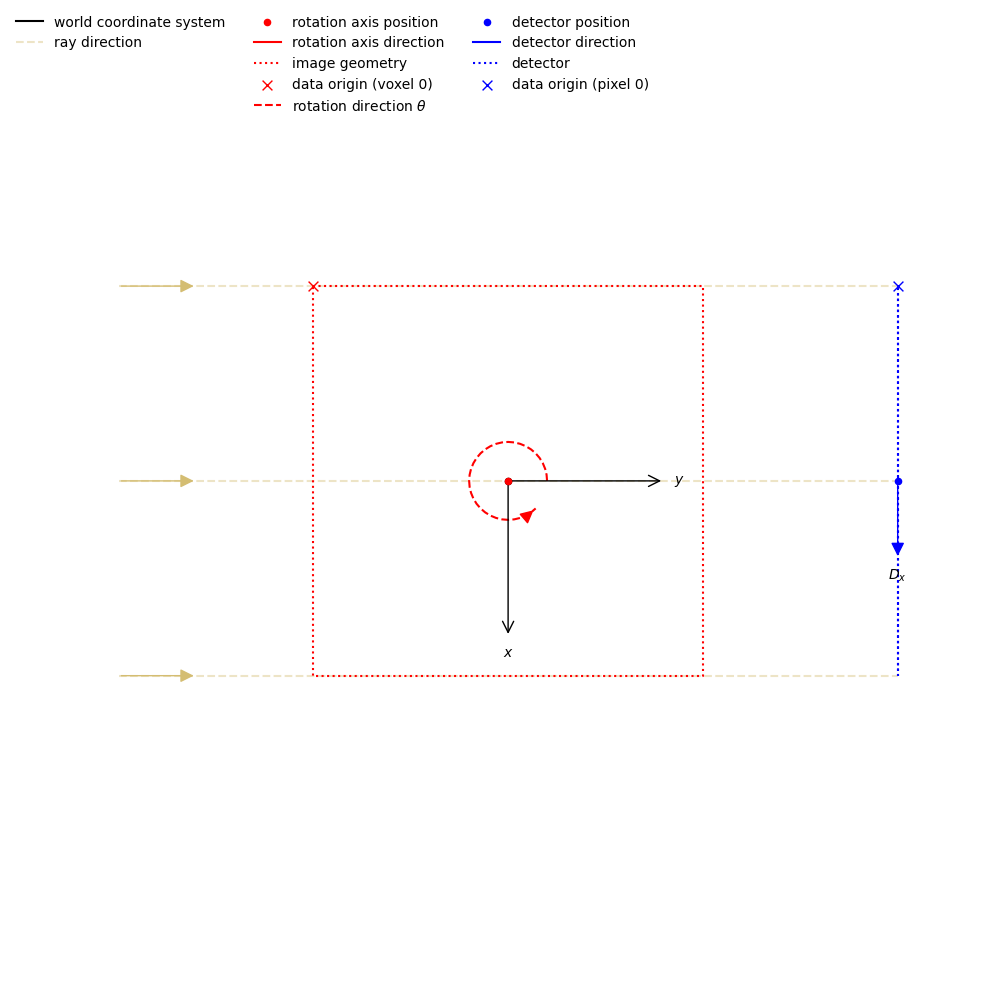

In [112]:
N_files = 100
N_pixels = 256

reader = TIFFStackReader(file_name=upper_path + subfolder_normalizations + 'sinogram_normalized_idx_0100.tiff')
sin1 = reader.read()
results = [sin1]
cmap = 'viridis'
show2D(results, ["Original sinogram"], fix_range=True, cmap=cmap, size=(10,10))

angles = np.linspace(0, 360, 100, endpoint=False, dtype=np.float32)
ig = ImageGeometry(voxel_num_x=N_pixels, 
                   voxel_num_y=N_pixels, 
                   voxel_size_x=1/N_pixels, 
                   voxel_size_y=1/N_pixels)
ag = AcquisitionGeometry.create_Parallel2D(detector_position=[0,1])\
                            .set_angles(angles)\
                            .set_panel(N_pixels, pixel_size=1/N_pixels)

sin1 = AcquisitionData(sin1, geometry=ag)
sin1.reorder('astra')
#recon_fbp = FBP(sin1, ig, backend='astra').run()

show_geometry(ag)
device = 'cpu'
fbp = FBP(ig,ag,device)
recon_fbp = fbp(sin1)

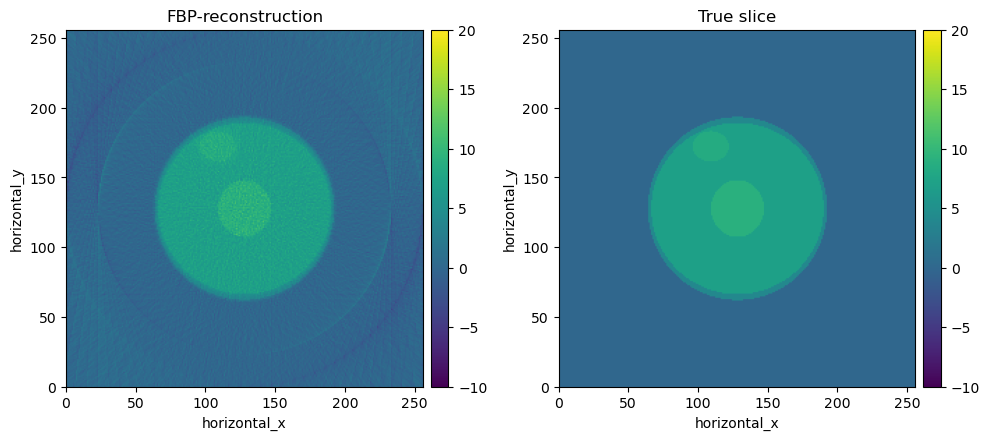

In [113]:
cmap = 'viridis'
size_x, size_y, n_slice = 256, 256, 128  # Custom size: 256x256x128
phantom_3d = cph.create_3d_shepp_logan(n_slice = n_slice,size_x=size_x, size_y=size_y,flat=False)
true_slice = int(100/256*128)
phantom_slice = phantom_3d.get_slice(vertical=true_slice-1)


results = [recon_fbp, phantom_slice]
show2D(results, ["FBP-reconstruction","True slice"], fix_range=(-10,20), cmap=cmap, size=(10,10))

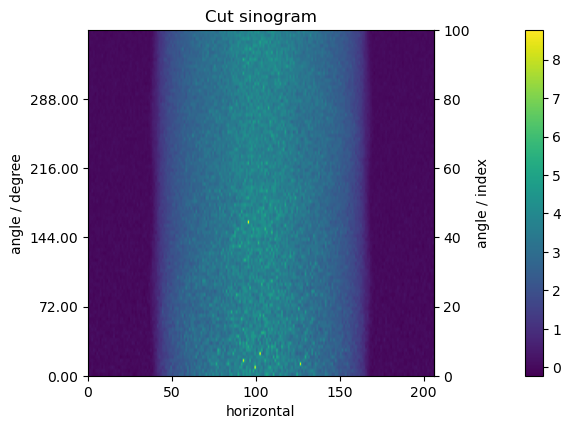

In [107]:
# Let us now see what happens by cutting off the outer edges of the sinograms
new_range = range(256)[25:-25]
ag2 = AcquisitionGeometry.create_Parallel2D()\
                            .set_angles(angles)\
                            .set_panel(len(new_range), pixel_size=1/len(new_range))
sin2 = AcquisitionData(geometry=ag2)
sin2.fill(sin1.as_array()[:,new_range])
results = [sin2]
show2D(results, ['Cut sinogram'], fix_range=True, cmap=cmap, size=(8,8))

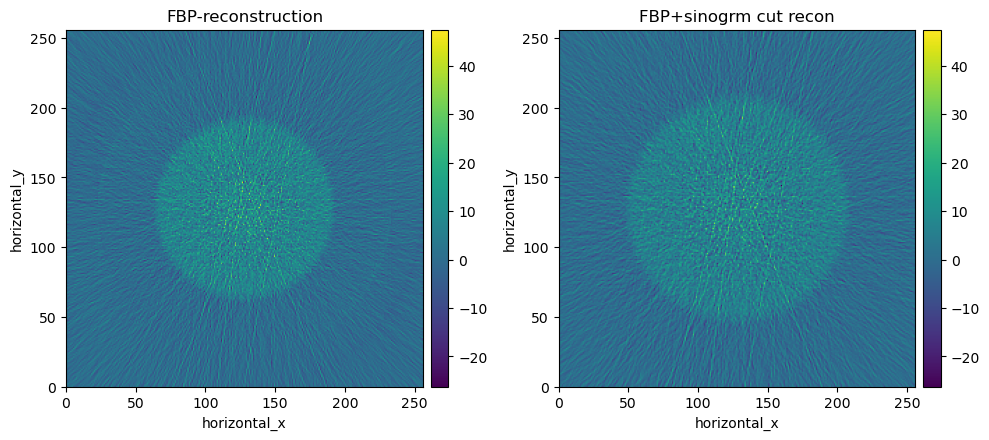

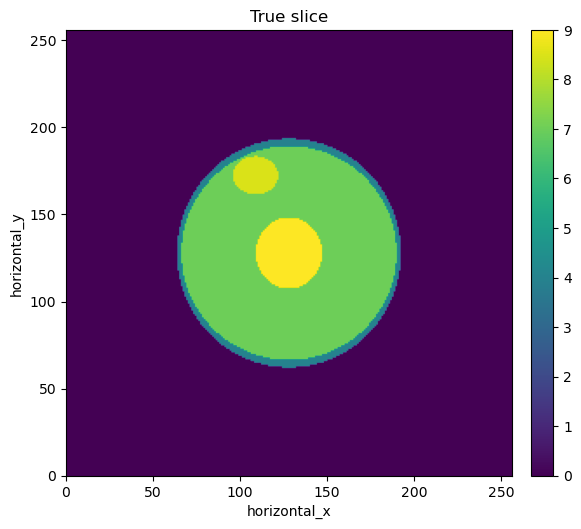

In [108]:
fbp = FBP(ig,ag2,device)
recon_fbp2 = fbp(sin2)
results = [recon_fbp,recon_fbp2]
show2D(results, ["FBP-reconstruction",'FBP+sinogrm cut recon'], fix_range=True, cmap=cmap, size=(10,10))
show2D(phantom_slice, ["True slice"], fix_range=True, cmap=cmap, size=(10,10))

In [109]:
np.mean(sin1.as_array()[25:35,25:35])


0.0018919295

-0.0002494023


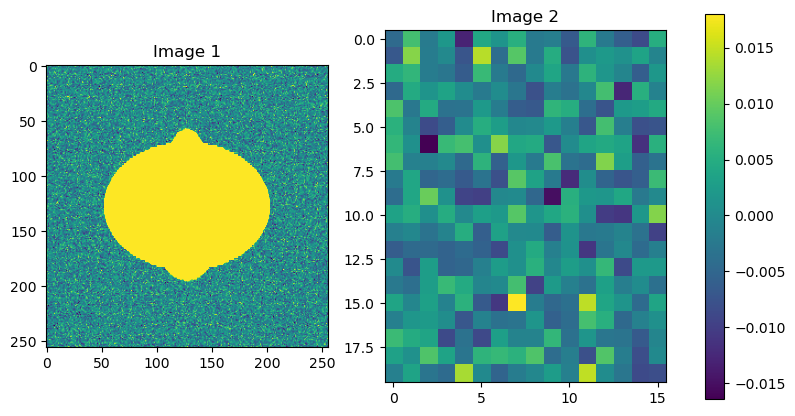

In [102]:
reader = TIFFStackReader(file_name=upper_path + subfolder_normalizations)
sin = reader.read()
sin = np.array(sin)
np.shape(sin)
print(np.mean(sin[200:220,50,120:136]))
image1 = sin[:,-1,:]

image2 = sin[200:220,-50,120:136]

vmin = image2.min()
vmax = image2.max()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
cax1 = ax1.imshow(image1, cmap='viridis', vmin=vmin, vmax=vmax)
ax1.set_title('Image 1')

# Plot the second image with the same color scale
cax2 = ax2.imshow(image2, cmap='viridis', vmin=vmin, vmax=vmax)
ax2.set_title('Image 2')

# Create a single color bar for both images
fig.colorbar(cax1, ax=[ax1, ax2], orientation='vertical')

plt.show()


In [94]:
upper_path = '/work3/msaca/simulation_data/experiment_1/'
subfolder_projections = 'projections/'
subfolder_flats = 'flats/'
subfolder_normalizations = 'normalizations/'
filename_prefix_projections = 'proj_simx3_'
filename_prefix_normalized = 'sinogram_normalized_idx_'
filename_prefix_flats = 'flat_simx3_'
filename_suffix = '.fits'
N_pixels = 256
OB_reg_TL = (210, 130)
OB_reg_BR = (220 , 146)

path = upper_path + subfolder_projections + filename_prefix_projections + f"{(1):05}" + filename_suffix
data = fits.open(path)[0].data
path = upper_path + subfolder_flats + filename_prefix_flats + f"{(1):05}" + filename_suffix
flat = fits.open(path)[0].data
path = upper_path + subfolder_normalizations + filename_prefix_normalized + f"{(1):04}" + '.tiff'
normal = TIFFStackReader(file_name=path)
normal = normal.read()
print(data[OB_reg_TL[0]:OB_reg_BR[0], OB_reg_TL[1]:OB_reg_BR[1]])
print(1)
print(flat[OB_reg_TL[0]:OB_reg_BR[0], OB_reg_TL[1]:OB_reg_BR[1]])
print(normal[0:10,25:35])




[[727570. 730323. 723704. 727046. 720755. 717805. 729340. 723704. 724818.
  720099. 714463. 724359. 719444. 728160. 721606. 732027.]
 [709941. 720820. 739039. 733337. 718657. 721606. 727832. 729667. 727636.
  727636. 716626. 720623. 715643. 719509. 726587. 734386.]
 [726456. 732682. 730323. 719968. 733337. 721803. 725801. 728684. 717805.
  720689. 721344. 709614. 712825. 719575. 729929. 720427.]
 [722458. 728488. 707910. 720165. 724621. 726522. 731895. 720689. 712956.
  727636. 734320. 746313. 732354. 735172. 723507. 729471.]
 [735631. 718985. 728684. 717019. 728094. 721148. 723638. 724490. 725997.
  725670. 725342. 727701. 722000. 733862. 724031. 718199.]
 [722917. 722458. 701946. 727636. 717478. 727636. 728160. 724687. 727832.
  733796. 727963. 728946. 723769. 717936. 729143. 718068.]
 [721475. 718330. 722327. 730060. 728553. 719575. 717216. 715905. 719313.
  722852. 720099. 704305. 727111. 719051. 716560. 727701.]
 [726391. 733730. 703781. 722196. 737466. 714791. 720820. 734976. 728

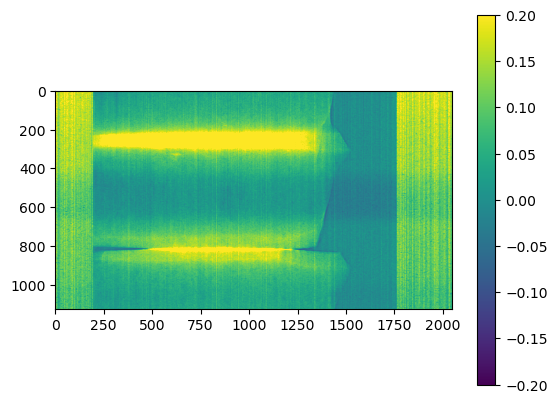

In [15]:
path = '/work3/msaca/Mars_data_1/02_filtereddata/normalizations/'

reader = TIFFStackReader(file_name=path + 'sinogram_normalized_idx_0001.tiff')
sin = reader.read()

plt.imshow(sin)
plt.colorbar()
plt.clim([-0.2,0.2])

In [16]:
path = '/work3/msaca/Mars_data_1/02_filtereddata/filtered_projections/'
doses = np.load(file=path + 'dose.npy')

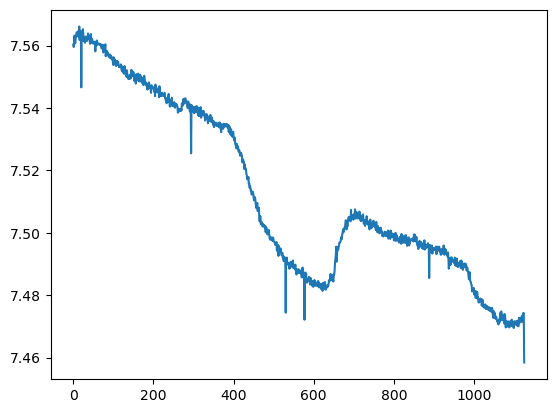

In [17]:
plt.plot(np.log(doses))

In [2]:
path = '/work3/msaca/Mars_data_1/02_filtereddata/filtered_projections/'
nproj = 200
fileskip = int(1125/nproj)
A = np.zeros((nproj,2048,2048))
filecount = 1
for i in range(nproj):
    proj = np.load(file=path + 'filter_proj' + f"{filecount:05}" + '.npy')
    filecount = filecount + fileskip
    A[i,:,:] = proj

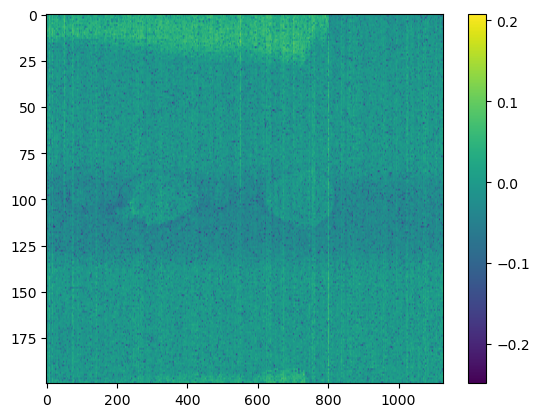

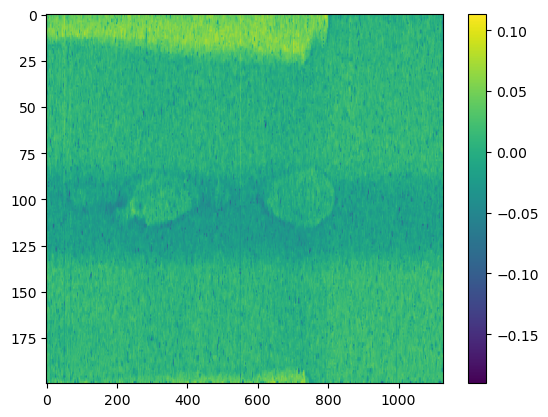

In [3]:
sin = A[:,:,500]
means = np.mean(sin,axis=0)
index = median_filter(means,size=10)<0.05
sin = sin[:,index]
plt.imshow(sin,aspect='auto')
plt.colorbar()
plt.show()
sin2 = np.apply_along_axis(median_filter, axis=0, arr=sin, size=3)
plt.imshow(sin2-means[index],aspect='auto')
plt.colorbar()
plt.show()

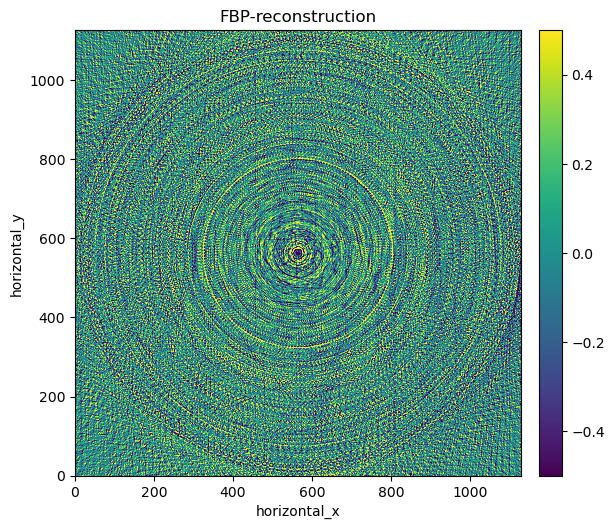

In [8]:
N_pixels = 1127
cmap='viridis'

angles = np.linspace(0, 360, 200, endpoint=False, dtype=np.float32)
ig = ImageGeometry(voxel_num_x=N_pixels, 
                   voxel_num_y=N_pixels, 
                   voxel_size_x=1/N_pixels, 
                   voxel_size_y=1/N_pixels)
ag2 = AcquisitionGeometry.create_Parallel2D(detector_position=[0,1])\
                            .set_angles(angles)\
                            .set_panel(N_pixels, pixel_size=1/N_pixels)
sin3 = AcquisitionData(geometry=ag2)
sin3.fill(sin2)
fbp = FBP(ig,ag2,'cpu')
recon_fbp2 = fbp(sin3)
results = [recon_fbp2]
show2D(results, ["FBP-reconstruction"], fix_range=(-0.5,0.5), cmap=cmap, size=(10,10))